In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import v2

import os
import pandas as pd
from torchvision.io import read_image

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.0+cu121  Device: cuda


In [ ]:
dataset_path = '/content/drive/MyDrive/CKplus'
label_dict = { 'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6 }
image_dict = dict()

for root, dir, files in os.walk(dataset_path):
  for name in files:
    image_dict[os.path.join(root, name)] = label_dict[os.path.basename(root)]

df = pd.DataFrame.from_dict(image_dict, orient='index')
df.reset_index(inplace=True)

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, img_dir, transform=None, target_transform=None):
        self.data_frame = data_frame
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = read_image(img_path)
        label = self.data_frame.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
batch_size = 32

train_augmentations = transforms.v2.Compose([
                                          transforms.v2.RandomCrop(32, padding=4),
                                          transforms.v2.RandomHorizontalFlip(),
                                          #transforms.ToTensor(),
                                          transforms.v2.ToDtype(torch.float32, scale=True),
                                          transforms.v2.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                         ])

test_augmentations = transforms.v2.Compose([
                                        #transforms.ToTensor(),
                                        transforms.v2.ToDtype(torch.float32, scale=True),
                                        transforms.v2.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                       )

dataset = CustomImageDataset(df, dataset_path, train_augmentations)

train_set, test_set = torch.utils.data.random_split(dataset, lengths=[0.7, 0.3])


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2,
                                          pin_memory=True
                                          )

In [ ]:
@torch.no_grad()
def test(
        model: nn.Module,
        criterion: nn.CrossEntropyLoss,
        loader: torch.utils.data.DataLoader,
        device: torch.device
) -> Tuple[float, float]:
    model.eval()
    accuracy, test_loss = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        test_loss += criterion(y_hat, y).item() * x.shape[0]
        _, predicted = torch.max(y_hat, axis=1)
        accuracy += (predicted == y).sum().item()
    accuracy /= len(loader.dataset)
    test_loss /= len(loader.dataset)
    return accuracy, test_loss

In [ ]:
def plot(x_epochs, train_loss, test_loss, test_acc):
    plt.title('Loss curves')
    plt.plot(x_epochs, train_loss, 'red', label='Train loss')
    plt.plot(x_epochs, test_loss, 'green', label='Test loss')
    plt.legend(loc='best')
    plt.show()

    plt.title('Test accuracy')
    plt.plot(x_epochs, test_acc)
    plt.show()

In [ ]:
def train(model: nn.Module,
          epochs: int,
          criterion: nn.CrossEntropyLoss,
          scheduler,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          device: torch.device) -> float:
    train_losses = []
    test_accuracies = []
    test_losses = []
    test_accuracy_untrained, test_loss_untrained = test(model, criterion, test_loader, device)
    print(f'On untrained model, test set: acc={test_accuracy_untrained*100:.2f}, loss={test_loss_untrained:.4f}')

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_train_loss += loss.item() * x.shape[0]

            model.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        train_losses.append(running_train_loss / len(train_loader.dataset))
        test_accuracy, test_loss = test(model, criterion, test_loader, device)
        print(f'Epoch {epoch}/{epochs}, train set: loss={train_losses[-1]:.4f}')
        print(f'Epoch {epoch}/{epochs}, test set: acc={test_accuracy*100:.2f}%, loss={test_loss:.4f}')
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    x_epochs = list(range(1, epochs+1))
    plot(x_epochs, train_losses, test_losses, test_accuracies)
    return test_accuracies[-1]

In [ ]:

class SimpleNet(nn.Module):
    def __init__(self, classes=10):
        super(SimpleNet, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Linear(300, classes)
        self.drp = nn.Dropout(0.1)


    def forward(self, x):
        out = self.features(x)

        out = F.max_pool2d(out, kernel_size=out.size()[2:])
        out = self.drp(out)

        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self):

        model = nn.Sequential(
                             nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.12),


                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),



                             nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.Conv2d(2048, 300, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(300, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(300, 300, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(300, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                            )

        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

        return model

In [ ]:
model = SimpleNet(classes=7)
model.to(device)


SimpleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (13): Dropout2d(p=0.12, inplace=False)
    (14): Conv2d(128, 128, kernel_size=

On untrained model, test set: acc=14.97, loss=1.9290
Epoch 1/50, train set: loss=1.8788
Epoch 1/50, test set: acc=18.37%, loss=3.0278
Epoch 2/50, train set: loss=1.6136
Epoch 2/50, test set: acc=31.29%, loss=1.9284
Epoch 3/50, train set: loss=1.4148
Epoch 3/50, test set: acc=31.63%, loss=2.1477
Epoch 4/50, train set: loss=1.3100
Epoch 4/50, test set: acc=51.02%, loss=1.2240
Epoch 5/50, train set: loss=1.1056
Epoch 5/50, test set: acc=52.04%, loss=1.4616
Epoch 6/50, train set: loss=1.0952
Epoch 6/50, test set: acc=58.16%, loss=1.0878
Epoch 7/50, train set: loss=1.0706
Epoch 7/50, test set: acc=56.80%, loss=1.2265
Epoch 8/50, train set: loss=0.9057
Epoch 8/50, test set: acc=63.95%, loss=0.9585
Epoch 9/50, train set: loss=0.8292
Epoch 9/50, test set: acc=61.90%, loss=1.1250
Epoch 10/50, train set: loss=0.8278
Epoch 10/50, test set: acc=60.20%, loss=1.0848
Epoch 11/50, train set: loss=0.7453
Epoch 11/50, test set: acc=70.41%, loss=0.8063
Epoch 12/50, train set: loss=0.6679
Epoch 12/50, tes

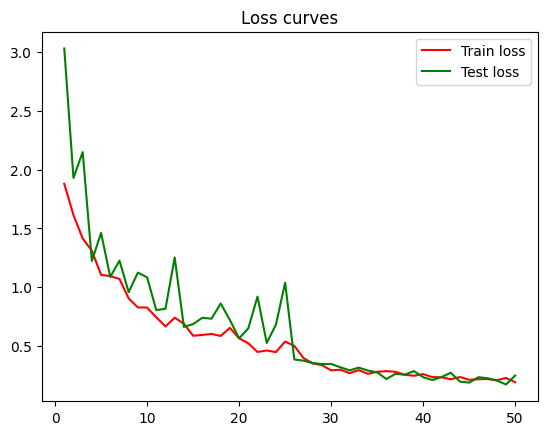

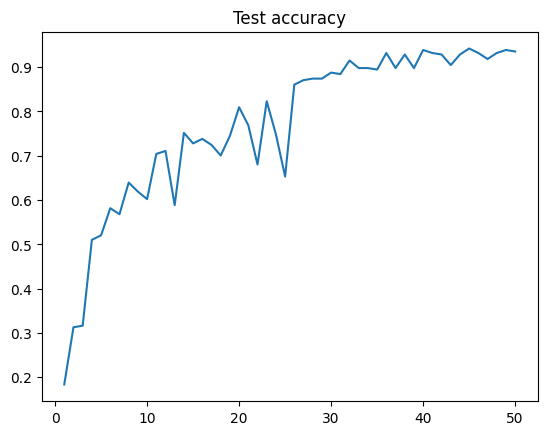

accuracy: 0.935374149659864


In [ ]:
epochs = 50

lr = 0.001
momentum = 0.9
weight_decay = 1e-3


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

model_accuracy = train(model, epochs, criterion, scheduler, train_loader, test_loader, device)

print(f"accuracy: {model_accuracy}")

SimpleNet paper: [here](https://arxiv.org/pdf/1608.06037v8.pdf)

SimpleNet code: [here](https://github.com/Coderx7/SimpleNet_Pytorch/tree/5d13ddbba6ae531ced26469c6b0f0ec18665d5ec)